# Import Statements

In [267]:
# IMPORT STATEMENTS

#Import Python packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import ast

# Import Snowflake modules
from snowflake.snowpark import Session
from pyspark.sql.functions import year
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T

# import matplotlib and seaborn to plot charts and graphs
import matplotlib.pyplot as plt
import seaborn as sns

# to split training and testing data
from sklearn.model_selection import train_test_split

# DATA PREPARATION
from feature_engine.encoding import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# MODEL BUILDING
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn. ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR

# MODEL EVALUATION & IMPROVEMENT
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# to export model
import joblib

# Functions

In [268]:
def model_performance(model):
    print('the training root mean squared error is: ',  np.sqrt(mean_squared_error(model.predict(X_train_scaled), y_train)))
    print('the testing root mean squared error is: ',  np.sqrt(mean_squared_error(model.predict(X_test_scaled), y_test)))

    print()

    #training mse
    train_mse = mean_squared_error(model.predict(X_train_scaled), y_train)
    print('the training mean squared error is: ', train_mse)
    #testing mse
    test_mse = mean_squared_error(model.predict(X_test_scaled), y_test)
    print('the testing mean squared error is: ', test_mse)

    print()

    print('training accuracy is: ', model.score(X_train_scaled, y_train))
    print('testing accuracy is: ', model.score(X_test_scaled, y_test))


# Load Tables From Snowflake

In [269]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "raw_pos",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

In [270]:
# retrieve order details usa table from snowflake
order_detail = session.table("frostbyte_tasty_bytes.raw_pos.ORDER_DETAIL")
order_header = session.table("frostbyte_tasty_bytes.raw_pos.ORDER_HEADER")
location_table = session.table("frostbyte_tasty_bytes.raw_pos.LOCATION")

In [271]:
location_table.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"LOCATION_ID"  |"PLACEKEY"           |"LOCATION"                                          |"CITY"      |"REGION"                               |"ISO_COUNTRY_CODE"  |"COUNTRY"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1001           |222-222@4hf-nch-k2k  |Seasoners Fine Foods                                |Manchester  |Greater Manchester                     |GB                  |England    |
|1002           |222-222@4hf-ndn-4sq  |HM Music Promotions                                 |Manchester  |Greater Manchester                     |GB                  |England    |
|1003           |222-222@4hf-ndp-grk  |G J Hull                                            |Manchester  |

In [272]:
# Get a list of LOCATION_IDs where the COUNTRY column's value is 'United States'
## Filter the 'location_table' where the 'COUNTRY' column is 'United States'
filtered_location_table = location_table.filter(location_table['COUNTRY'] == 'United States')

## Select the 'LOCATION_ID' column from the filtered DataFrame
location_id_df = filtered_location_table.select('LOCATION_ID')

## Convert the 'LOCATION_ID' column to a Python list
location_id_list = location_id_df.collect()

## Extract the values from the DataFrame and convert them to a list
location_id_list = [row['LOCATION_ID'] for row in location_id_list]

In [273]:
order_detail.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_DETAIL_ID"  |"ORDER_ID"  |"MENU_ITEM_ID"  |"DISCOUNT_ID"  |"LINE_NUMBER"  |"QUANTITY"  |"UNIT_PRICE"  |"PRICE"  |"ORDER_ITEM_DISCOUNT_AMOUNT"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------
|716664763          |390479600   |17              |NULL           |0              |5           |4.0000        |20.0000  |NULL                          |
|716664764          |390479600   |18              |NULL           |1              |1           |5.0000        |5.0000   |NULL                          |
|716664765          |390479600   |19              |NULL           |2              |2           |3.0000        |6.0000   |NULL                          |
|716664766          |390479600   |12              |NULL           |3              

In [274]:
order_header.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|14271673    |90          |2666.0         |NULL           |NULL           |63645       |15:30:00            |22:30:00          |NULL             |2021-05-

In [275]:
# Merge the two tables using the 'ORDER_ID' column as the common key
merged_df = order_detail.join(order_header, on='ORDER_ID', how='inner')

In [276]:
# Get rows where the LOCATION_ID is for United States
merged_df = merged_df.filter(F.col('LOCATION_ID').isin(location_id_list))

In [277]:
# Filter table for only the required columns
order_df = merged_df.select("MENU_ITEM_ID", "QUANTITY", "ORDER_TS")

In [278]:
# Convert the 'ORDER_TS' column to a java.sql.Timestamp object
order_df = order_df.withColumn('ORDER_TS', F.to_timestamp(order_df['ORDER_TS']))

# Extract the year from the 'ORDER_TS' column
order_df = order_df.withColumn('YEAR', F.year(order_df['ORDER_TS']))

# Drop the 'ORDER_TS' column
order_df = order_df.drop('ORDER_TS')

# Show the modified DataFrame with the 'YEAR' column
order_df.show()

----------------------------------------
|"MENU_ITEM_ID"  |"QUANTITY"  |"YEAR"  |
----------------------------------------
|133             |1           |2021    |
|132             |2           |2021    |
|136             |1           |2021    |
|131             |3           |2021    |
|132             |1           |2021    |
|131             |1           |2021    |
|132             |4           |2021    |
|133             |1           |2021    |
|135             |1           |2021    |
|136             |1           |2021    |
----------------------------------------



In [279]:
# Group by 'YEAR' and 'MENU_ITEM_ID' and calculate the sum of 'QUANTITY'
total_qty_by_item = order_df.group_by(['YEAR', 'MENU_ITEM_ID']) \
                           .agg(F.sum(order_df['QUANTITY']).alias('TOTAL_QTY_SOLD_PER_YEAR')) \
                           .orderBy(['YEAR', 'MENU_ITEM_ID'])

# View the data
total_qty_by_item.show()

-------------------------------------------------------
|"YEAR"  |"MENU_ITEM_ID"  |"TOTAL_QTY_SOLD_PER_YEAR"  |
-------------------------------------------------------
|2019    |10              |5305                       |
|2019    |11              |15597                      |
|2019    |12              |15612                      |
|2019    |13              |15641                      |
|2019    |14              |5211                       |
|2019    |15              |5211                       |
|2019    |16              |5349                       |
|2019    |17              |15560                      |
|2019    |18              |15759                      |
|2019    |19              |15658                      |
-------------------------------------------------------



In [280]:
order_df_grp_by = total_qty_by_item.to_pandas()

In [281]:
order_df_grp_by[order_df_grp_by["YEAR"]==2022].head()

,YEAR,MENU_ITEM_ID,TOTAL_QTY_SOLD_PER_YEAR
228,2022,10,149318
229,2022,11,443405
230,2022,12,441775
231,2022,13,441694
232,2022,14,149397


In [282]:
order_df_grp_by["TOTAL_QTY_SOLD_PER_YEAR"] = np.where(
    order_df_grp_by["YEAR"] == 2022,
    np.ceil((order_df_grp_by["TOTAL_QTY_SOLD_PER_YEAR"] / 11) * 12),
    order_df_grp_by["TOTAL_QTY_SOLD_PER_YEAR"]
)

In [283]:
order_df_grp_by[order_df_grp_by["YEAR"]==2022].head()

,YEAR,MENU_ITEM_ID,TOTAL_QTY_SOLD_PER_YEAR
228,2022,10,162893.0
229,2022,11,483715.0
230,2022,12,481937.0
231,2022,13,481848.0
232,2022,14,162979.0


In [284]:
order_df_grp_by.to_csv('StreamlitApp/assets/total_qty_by_item.csv', index=False)

# Menu Table 

In [285]:
# retrieve menu data from snowflake
menu_data_from_snowflake = session.table("frostbyte_tasty_bytes.raw_pos.MENU")

In [286]:
# convert menu_data_from_snowflake to pandas dataframe
menu_df = menu_data_from_snowflake.to_pandas()

In [287]:
# merge total_qty_sold_per_item with final_product_df
menu_df = pd.merge(menu_df, order_df_grp_by, on='MENU_ITEM_ID')

In [288]:
# preview menu table
menu_df.head()

,MENU_ID,MENU_TYPE_ID,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,MENU_ITEM_NAME,ITEM_CATEGORY,ITEM_SUBCATEGORY,COST_OF_GOODS_USD,SALE_PRICE_USD,MENU_ITEM_HEALTH_METRICS_OBJ,YEAR,TOTAL_QTY_SOLD_PER_YEAR
0,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,"{\n ""menu_item_health_metrics"": [\n {\n ...",2019,5305.0
1,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,"{\n ""menu_item_health_metrics"": [\n {\n ...",2020,26284.0
2,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,"{\n ""menu_item_health_metrics"": [\n {\n ...",2021,159322.0
3,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,"{\n ""menu_item_health_metrics"": [\n {\n ...",2022,162893.0
4,10002,1,Ice Cream,Freezing Point,11,Sugar Cone,Dessert,Cold Option,2.50,6.0,"{\n ""menu_item_health_metrics"": [\n {\n ...",2019,15597.0


In [289]:
# Convert the string JSON data to a nested dictionary
menu_df['MENU_ITEM_HEALTH_METRICS_OBJ'] = menu_df['MENU_ITEM_HEALTH_METRICS_OBJ'].apply(ast.literal_eval)

# Use json_normalize to flatten the nested JSON data
menu_item_metrics = pd.json_normalize(menu_df['MENU_ITEM_HEALTH_METRICS_OBJ'], record_path='menu_item_health_metrics')

# Rename the columns
menu_item_metrics = menu_item_metrics.rename(columns={
    'is_dairy_free_flag': 'DAIRY_FREE',
    'is_gluten_free_flag': 'GLUTEN_FREE',
    'is_healthy_flag': 'HEALTHY',
    'is_nut_free_flag': 'NUT_FREE'
})

# Replace 'Y' with 'Yes' and 'N' with 'No' in the DataFrame
menu_item_metrics = menu_item_metrics.replace({'Y': 1, 'N': 0})

# Concatenate the flattened DataFrame with the original DataFrame
menu_df = pd.concat([menu_df, menu_item_metrics], axis=1)

# Drop the original 'MENU_ITEM_HEALTH_METRICS_OBJ' and 'ingredients' column 
menu_df = menu_df.drop(columns=['MENU_ITEM_HEALTH_METRICS_OBJ', 'ingredients'])

In [290]:
menu_df.head()

,MENU_ID,MENU_TYPE_ID,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,MENU_ITEM_NAME,ITEM_CATEGORY,ITEM_SUBCATEGORY,COST_OF_GOODS_USD,SALE_PRICE_USD,YEAR,TOTAL_QTY_SOLD_PER_YEAR,DAIRY_FREE,GLUTEN_FREE,HEALTHY,NUT_FREE
0,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2019,5305.0,1,1,0,1
1,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2020,26284.0,1,1,0,1
2,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2021,159322.0,1,1,0,1
3,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2022,162893.0,1,1,0,1
4,10002,1,Ice Cream,Freezing Point,11,Sugar Cone,Dessert,Cold Option,2.50,6.0,2019,15597.0,1,1,0,1


# Final Table

In [291]:
final_df = menu_df

In [292]:
final_df.head()

,MENU_ID,MENU_TYPE_ID,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,MENU_ITEM_NAME,ITEM_CATEGORY,ITEM_SUBCATEGORY,COST_OF_GOODS_USD,SALE_PRICE_USD,YEAR,TOTAL_QTY_SOLD_PER_YEAR,DAIRY_FREE,GLUTEN_FREE,HEALTHY,NUT_FREE
0,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2019,5305.0,1,1,0,1
1,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2020,26284.0,1,1,0,1
2,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2021,159322.0,1,1,0,1
3,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2022,162893.0,1,1,0,1
4,10002,1,Ice Cream,Freezing Point,11,Sugar Cone,Dessert,Cold Option,2.50,6.0,2019,15597.0,1,1,0,1


In [293]:
final_df['TOTAL_QTY_SOLD_PER_YEAR'] = final_df['TOTAL_QTY_SOLD_PER_YEAR'].astype(int)

In [294]:
# Calculate the minimum and maximum values of the 'TOTAL_QTY_SOLD' column
min_value = final_df['TOTAL_QTY_SOLD_PER_YEAR'].min()
max_value = final_df['TOTAL_QTY_SOLD_PER_YEAR'].max()

# Calculate the range
column_range = max_value - min_value

print("Range: {} - {}".format(min_value, max_value))

Range: 5211 - 1013940


In [295]:
final_df = final_df.drop(["COST_OF_GOODS_USD", "MENU_ID", "MENU_TYPE_ID", "MENU_ITEM_NAME"], axis=1)
final_df.head()

,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,ITEM_CATEGORY,ITEM_SUBCATEGORY,SALE_PRICE_USD,YEAR,TOTAL_QTY_SOLD_PER_YEAR,DAIRY_FREE,GLUTEN_FREE,HEALTHY,NUT_FREE
0,Ice Cream,Freezing Point,10,Beverage,Cold Option,3.5,2019,5305,1,1,0,1
1,Ice Cream,Freezing Point,10,Beverage,Cold Option,3.5,2020,26284,1,1,0,1
2,Ice Cream,Freezing Point,10,Beverage,Cold Option,3.5,2021,159322,1,1,0,1
3,Ice Cream,Freezing Point,10,Beverage,Cold Option,3.5,2022,162893,1,1,0,1
4,Ice Cream,Freezing Point,11,Dessert,Cold Option,6.0,2019,15597,1,1,0,1


In [296]:
# Define the mapping dictionary
temperature_mapping = {'Cold Option': 0, 'Warm Option': 1, 'Hot Option': 2}

# Apply the mapping to the 'ITEM_SUBCATEGORY' column in final_df
final_df['ITEM_SUBCATEGORY'] = final_df['ITEM_SUBCATEGORY'].map(temperature_mapping)

final_df.head()

,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,ITEM_CATEGORY,ITEM_SUBCATEGORY,SALE_PRICE_USD,YEAR,TOTAL_QTY_SOLD_PER_YEAR,DAIRY_FREE,GLUTEN_FREE,HEALTHY,NUT_FREE
0,Ice Cream,Freezing Point,10,Beverage,0,3.5,2019,5305,1,1,0,1
1,Ice Cream,Freezing Point,10,Beverage,0,3.5,2020,26284,1,1,0,1
2,Ice Cream,Freezing Point,10,Beverage,0,3.5,2021,159322,1,1,0,1
3,Ice Cream,Freezing Point,10,Beverage,0,3.5,2022,162893,1,1,0,1
4,Ice Cream,Freezing Point,11,Dessert,0,6.0,2019,15597,1,1,0,1


# Check for Missing Values

In [297]:
final_df.isnull().sum()

MENU_TYPE                  0
TRUCK_BRAND_NAME           0
MENU_ITEM_ID               0
ITEM_CATEGORY              0
ITEM_SUBCATEGORY           0
SALE_PRICE_USD             0
YEAR                       0
TOTAL_QTY_SOLD_PER_YEAR    0
DAIRY_FREE                 0
GLUTEN_FREE                0
HEALTHY                    0
NUT_FREE                   0
dtype: int64

No missing values have been detected. Hence, no process required at this stage.

# Dealing with Outliers

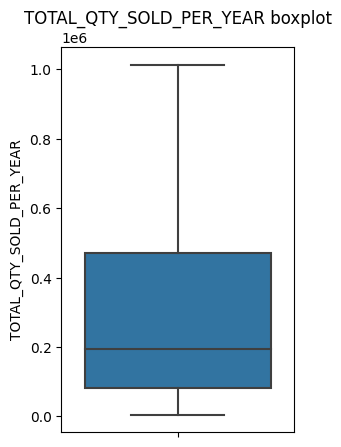

In [298]:
# plot box plot for 'minimum_nights' variable
plt.figure(figsize=(3,5))
sns.boxplot(y=final_df['TOTAL_QTY_SOLD_PER_YEAR'])
plt.title('TOTAL_QTY_SOLD_PER_YEAR boxplot')
plt.show()

Based on the boxplot shown above, there are no outliers detected. Hence, no process required for this stage.

Note: Outliers for the target variable wold not dealt with even if observed as it would be considered cherry picking convenient data. Furthermore, due to the relatively small number of menu items, if subsetting of the target variable was done, there might be too limited data to build an accurate model.

# Train Test Split

In [299]:
X_train, X_test, y_train, y_test = train_test_split(
    final_df.drop('TOTAL_QTY_SOLD_PER_YEAR', axis=1), final_df['TOTAL_QTY_SOLD_PER_YEAR'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((229, 11), (99, 11))

# Categorical Variable Encoding 

In [300]:
# Specify the columns to encode
columns_to_encode = ["MENU_TYPE", "TRUCK_BRAND_NAME", "ITEM_CATEGORY"]

ohe_enc = OneHotEncoder(variables=columns_to_encode, drop_last=True)

In [301]:
# fit the encoder to the train set: it will learn the variables and 
# categories to encode
ohe_enc.fit(X_train)

OneHotEncoder(drop_last=True,
              variables=['MENU_TYPE', 'TRUCK_BRAND_NAME', 'ITEM_CATEGORY'])

In [302]:
X_train = ohe_enc.transform(X_train)
X_test = ohe_enc.transform(X_test)

# Scaling

## Min Max Scaler

In [303]:
# set up the scaler
scaler = MinMaxScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [304]:
# Save the model to a file
joblib.dump(scaler, "StreamlitApp/assets/product_qty_year_min_max_scaler.joblib")

['StreamlitApp/assets/product_qty_year_min_max_scaler.joblib']

## Standard Scaler

In [305]:
# # set up the scaler
# scaler = StandardScaler()

# # fit the scaler to the train set, it will learn the parameters
# scaler.fit(X_train)

# # transform train and test sets
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Standard Scaler did not lead to a difference in result.

In [306]:
# # set up the scaler
# scaler = RobustScaler()

# # fit the scaler to the train set, it will learn the parameters
# scaler.fit(X_train)

# # transform train and test sets
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Robust Scaler did not lead to a difference in result.

In [307]:
# let's transform the returned NumPy arrays to dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Build Models

## Linear Regression

In [308]:
# create the linear regression model
# fit the model to the training data
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [309]:
# Calculated the fitted values for training set
y_fitted = lm.predict(X_train)

# Task 5a: calculated the predicated value for testing data
y_pred = lm.predict(X_test)

In [310]:
model_performance(lm)

the training root mean squared error is:  323818891.84701324
the testing root mean squared error is:  323906990.21192896

the training mean squared error is:  1.0485867471702765e+17
the testing mean squared error is:  1.0491573830815066e+17

training accuracy is:  -1036879.3099519674
testing accuracy is:  -1084446.6315793514


## Decision Tree

In [311]:
# Create Decision Tree Regressor with random state equal to 2
# fit the model to the training data
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=2)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

In [312]:
model_performance(tree_reg)

the training root mean squared error is:  424111.86399201246
the testing root mean squared error is:  384753.89341422403

the training mean squared error is:  179870873178.77927
the testing mean squared error is:  148035558497.40405

training accuracy is:  -0.7786279221652017
testing accuracy is:  -0.5301499411891819


## MLP Regressor

In [313]:
# Create the ann model
mlp = MLPRegressor(activation ='relu', hidden_layer_sizes=(10,), max_iter= 2000, solver = 'sgd', random_state=2)
# Fit the model to the training set
mlp.fit(X_train,y_train)

MLPRegressor(hidden_layer_sizes=(10,), max_iter=2000, random_state=2,
             solver='sgd')

In [314]:
model_performance(mlp)

the training root mean squared error is:  4481009344937.23
the testing root mean squared error is:  4481009290799.87

the training mean squared error is:  2.0079444749414788e+25
the testing mean squared error is:  2.007944426423475e+25

training accuracy is:  -198552775453451.5
testing accuracy is:  -207548515855863.78


## ADA Boost Regressor

In [315]:
# Build Ada Boost Model 
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=3), n_estimators = 20, learning_rate =0.1)
# fit the model to the training data
ada_reg.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3),
                  learning_rate=0.1, n_estimators=20)

In [316]:
model_performance(ada_reg)

the training root mean squared error is:  419027.13915994274
the testing root mean squared error is:  386159.252698129

the training mean squared error is:  175583743352.56604
the testing mean squared error is:  149118968444.37744

training accuracy is:  -0.7362352396808556
testing accuracy is:  -0.54134846459445


## SVR

In [317]:
svr = SVR(C=0.8, kernel ='rbf')
svr.fit(X_train, y_train)

SVR(C=0.8)

In [318]:
model_performance(svr)

the training root mean squared error is:  343012.1631203653
the testing root mean squared error is:  319820.1059251771

the training mean squared error is:  117657344048.5121
the testing mean squared error is:  102284900153.9915

training accuracy is:  -0.16343815801951833
testing accuracy is:  -0.05725432148733378


## XGBoost Regressor

In [319]:
# Build XGBoost Model
xgb = XGBRegressor(n_estimators = 20, learning_rate = 0.1, use_label_encoder = False, eval_metric='logloss')
# fit the model to the training data
xgb.fit(X_train_scaled, y_train)
model_performance(xgb)

the training root mean squared error is:  74067.87092797786
the testing root mean squared error is:  80073.27197659234

the training mean squared error is:  5486049503.803587
the testing mean squared error is:  6411728885.037329

training accuracy is:  0.9457519683014649
testing accuracy is:  0.9337260136960074


# Model Improvement (GridSearch CV)

In [320]:
param_grid = {'n_estimators': [10, 20, 30, 40],
              'learning_rate': [0.1, 0.2, 0.3, 0.4],
              'max_depth': [3,4,5,6,7,8]}

xgb_grid = GridSearchCV(xgb, param_grid, cv=5)
xgb_grid.fit(X_train_scaled, y_train)

best_params = xgb_grid.best_params_
print("Best parameters found: ", best_params)
print("Best score found: ", xgb_grid.best_score_)

Best parameters found:  {'learning_rate': 0.4, 'max_depth': 6, 'n_estimators': 40}
Best score found:  0.9309377100049401


# Improved Model 

In [321]:
# Build XGBoost Model
xgb_improved = XGBRegressor(**best_params)
# fit the model to the training data
xgb_improved.fit(X_train_scaled, y_train)

model_performance(xgb_improved)

the training root mean squared error is:  2097.6911689950866
the testing root mean squared error is:  30546.02122442688

the training mean squared error is:  4400308.240479973
the testing mean squared error is:  933059412.6431375

training accuracy is:  0.9999564881686271
testing accuracy is:  0.9903555549769689


In [322]:
# Save the model to a file
joblib.dump(xgb_improved, "StreamlitApp/assets/product_qty_year_xgb_model.joblib")

['StreamlitApp/assets/product_qty_year_xgb_model.joblib']

In [323]:
xgb_improved.feature_importances_

array([3.64614874e-02, 3.42726731e-03, 3.43160063e-01, 1.07064731e-01,
       1.48226367e-02, 1.12963695e-04, 4.75538243e-03, 9.73635295e-04,
       6.76029129e-03, 0.00000000e+00, 9.78633389e-02, 5.99104795e-04,
       4.87948209e-03, 4.39274721e-02, 3.27309477e-03, 4.25238907e-02,
       6.36005029e-02, 5.04708290e-03, 1.03021681e-03, 0.00000000e+00,
       2.41707321e-02, 7.38199288e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.87871963e-01, 1.11062300e-05, 2.81514920e-04], dtype=float32)

In [324]:
# Get the feature importances
feature_importance = xgb_improved.feature_importances_

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

                                  Feature  Importance
2                          SALE_PRICE_USD    0.343160
36                 ITEM_CATEGORY_Beverage    0.187872
3                                    YEAR    0.107065
10                      MENU_TYPE_Chinese    0.097863
16                        MENU_TYPE_Ramen    0.063601
13                        MENU_TYPE_Gyros    0.043927
15                   MENU_TYPE_Vegetarian    0.042524
0                            MENU_ITEM_ID    0.036461
20               MENU_TYPE_Grilled Cheese    0.024171
4                              DAIRY_FREE    0.014823
21                 MENU_TYPE_Mac & Cheese    0.007382
8                     MENU_TYPE_Ethiopian    0.006760
17                       MENU_TYPE_Crepes    0.005047
12                     MENU_TYPE_Hot Dogs    0.004879
6                                 HEALTHY    0.004755
1                        ITEM_SUBCATEGORY    0.003427
14                        MENU_TYPE_Tacos    0.003273
18                      MENU

In [325]:
X_train.head()

,MENU_ITEM_ID,ITEM_SUBCATEGORY,SALE_PRICE_USD,YEAR,DAIRY_FREE,GLUTEN_FREE,HEALTHY,NUT_FREE,MENU_TYPE_Ethiopian,MENU_TYPE_Ice Cream,...,TRUCK_BRAND_NAME_Plant Palace,TRUCK_BRAND_NAME_Kitakata Ramen Bar,TRUCK_BRAND_NAME_Le Coin des Crêpes,TRUCK_BRAND_NAME_Revenge of the Curds,TRUCK_BRAND_NAME_Better Off Bread,TRUCK_BRAND_NAME_The Mega Melt,TRUCK_BRAND_NAME_The Mac Shack,ITEM_CATEGORY_Beverage,ITEM_CATEGORY_Dessert,ITEM_CATEGORY_Main
216,95,0,3.0,2022,1,1,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
29,17,0,4.0,2020,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
276,131,2,13.0,2022,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
20,15,0,3.0,2019,1,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
46,22,2,17.0,2021,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [326]:
X_train.columns

Index(['MENU_ITEM_ID', 'ITEM_SUBCATEGORY', 'SALE_PRICE_USD', 'YEAR',
       'DAIRY_FREE', 'GLUTEN_FREE', 'HEALTHY', 'NUT_FREE',
       'MENU_TYPE_Ethiopian', 'MENU_TYPE_Ice Cream', 'MENU_TYPE_Chinese',
       'MENU_TYPE_BBQ', 'MENU_TYPE_Hot Dogs', 'MENU_TYPE_Gyros',
       'MENU_TYPE_Tacos', 'MENU_TYPE_Vegetarian', 'MENU_TYPE_Ramen',
       'MENU_TYPE_Crepes', 'MENU_TYPE_Poutine', 'MENU_TYPE_Sandwiches',
       'MENU_TYPE_Grilled Cheese', 'MENU_TYPE_Mac & Cheese',
       'TRUCK_BRAND_NAME_Tasty Tibs', 'TRUCK_BRAND_NAME_Freezing Point',
       'TRUCK_BRAND_NAME_Peking Truck', 'TRUCK_BRAND_NAME_Smoky BBQ',
       'TRUCK_BRAND_NAME_Amped Up Franks', 'TRUCK_BRAND_NAME_Cheeky Greek',
       'TRUCK_BRAND_NAME_Guac n' Roll', 'TRUCK_BRAND_NAME_Plant Palace',
       'TRUCK_BRAND_NAME_Kitakata Ramen Bar',
       'TRUCK_BRAND_NAME_Le Coin des Crêpes',
       'TRUCK_BRAND_NAME_Revenge of the Curds',
       'TRUCK_BRAND_NAME_Better Off Bread', 'TRUCK_BRAND_NAME_The Mega Melt',
       'TRUCK_BRAND_N